# DeepDream - Stylized 

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy


You should consider upgrading via the '/media/programming/projects/machineLearning/ML/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
import PIL
import PIL.Image


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Import all Modules and Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-07-16 13:14:17.244888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 13:14:17.267799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 13:14:17.267986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 13:14:17.268624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
tf.__version__


'2.9.1'

## Load DataSet

In [5]:
def load_from_directory(data_dir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    nrBatches = len(train_ds)

    # Translate [0,255] -> [0, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x: (normalization_layer(x), [1 for _ in range(0,batch_size)] ) ),
                                              AUTOTUNE)

    train_ds = normalized_ds.take(int(train_size * nrBatches))
    test_ds = normalized_ds.skip(int(train_size * nrBatches)).take(int((1.0 - train_size) * nrBatches))

    return train_ds, test_ds


In [6]:

latent_space_size = 128
BATCH_SIZE = 28
IMAGE_SIZE = (64, 64)
EPOCHS = 96

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 184438 files
Found 184438 files belonging to 1 classes.
Number of batches 5270 of 28 elements


2022-07-16 13:14:24.611327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 13:14:24.612248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 13:14:24.612501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 13:14:24.612727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Example Data 

2022-07-16 13:14:25.310682: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


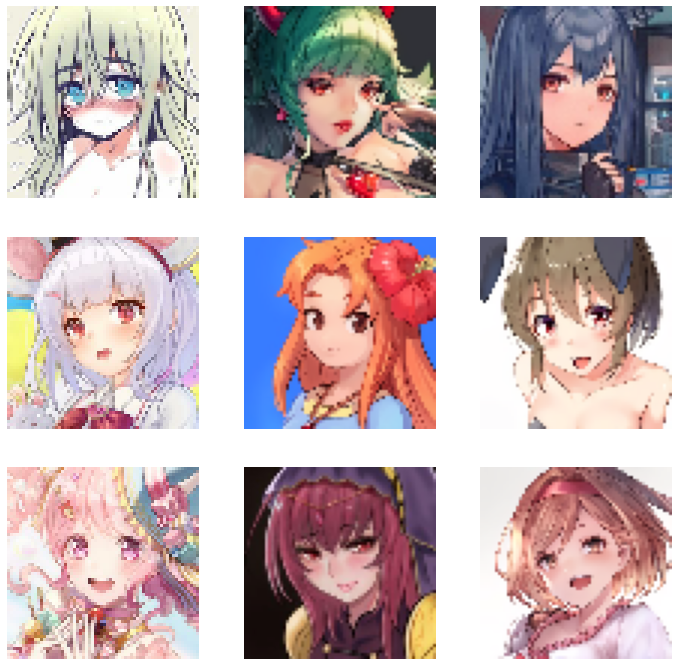

In [7]:
#TODO improve logic.
plt.figure(figsize=(12, 12))
for images in train_images.take(2):
    image,label = images
    for i in range(9):

        ax = plt.subplot(3, 3, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow(image[i].numpy().astype(dtype='float32') )
        plt.axis("off")
plt.show()

# Find Model - Hyperparamter

In [8]:
def make_classifier_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    n_layers = hp.Int('number_layers', min_value=1, max_value=3, step=1)
    hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)

    hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.5, step=0.1)

    #
    model.add(layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same',
                            input_shape=input_shape))
    model.add(layers.BatchNormalization(dtype='float32'))
    model.add(layers.LeakyReLU(alpha=0.2, dtype='float32'))

    max_filters_size = 1024
    
    #concatted = tf.keras.layers.Concatenate()([x1, x2])
    #
    for i in range(0, n_layers):
        filter_size = 128 * (2 ** i)
        filter_size = min(max_filters_size, filter_size)
        #
        model.add(layers.Conv2D(filter_size, kernel_size=4,
                                strides=(2, 2), use_bias=False, padding='same', kernel_initializer=kernel_init, dtype='float32'))
        model.add(layers.BatchNormalization(dtype='float32'))
        model.add(layers.LeakyReLU(alpha=0.2, dtype='float32'))
        model.add(layers.Dropout(hp_drop_rate))

    model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=64, max_value=1024, step=64)
    model.add(layers.Dense(units=hp_units, activation='relu', kernel_initializer=kernel_init))

    model.add(layers.Dense(1, activation='sigmoid', dtype='float32'))

    hp_learning_rate = hp.Choice('learning_rate', values=[2e-2, 2e-3, 2e-4])
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam'])

    optimizer = tf.keras.optimizers.get(hp_optimizer)

    optimizer.learning_rate = hp_learning_rate

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    return model


In [9]:

def model_builder(hp):
    model = make_classifier_model(hp, (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=6,
                     factor=4,
                     directory='cache',
                     project_name='DeepDream Image Classifier')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#
tuner.search(train_images, validation_data=validation_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[tf.keras.callbacks.TerminateOnNaN(), stop_early
                        ], verbose=1)
#
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#
model = model_builder(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project cache/DeepDream Image Classifier/oracle.json
INFO:tensorflow:Reloading Tuner from cache/DeepDream Image Classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Batc  (N

In [10]:
# Maximize the activations of these layers
names = ['conv2d_3', 'conv2d_4']
layers = [model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=model.input, outputs=layers)

dream_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                             

In [14]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model.summary()

import IPython.display as display
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)


class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img


get_tiled_gradients = DeepDream(dream_model)
def deprocess(img):
    img = img * 255
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    img = img.resize((max_dim, max_dim))
    # if max_dim:
    ##  img.thumbnail((max_dim, max_dim))
    return np.array(img)


url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

original_img = download(url, max_dim=64)

def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor([img])
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = dream_model(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))

        result = deprocess(img)
        display.clear_output(wait=True)
        show(result)

    return result


dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_193 (Conv2D)            (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_193 (Batch  (None, None, None,   96         ['conv2d_193[0][0]']             
 Normalization)                 32)                                                    